## Step 0
Load libraries, packages and dependencies for new task, assuming everything has been installed and downloaded. Make sure the working directory contains everything

In [1]:
import sys
sys.path.append('./deepfrag')

In [2]:
import torch
import prody
import py3Dmol
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import IPythonConsole
Draw.IPythonConsole.ipython_3d = True
import numpy as np
import time
import h5py
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from leadopt.model_conf import LeadoptModel, DIST_FN
from leadopt import grid_util
from leadopt.data_util import REC_TYPER, LIG_TYPER
from leadopt import util

In [4]:
def to2d(x):
  '''Remove 3d coordinate info from a rdkit mol for display purposes.'''
  return Chem.MolFromSmiles(Chem.MolToSmiles(x, isomericSmiles=False))

def tosdf(x):
  '''Rdkit mol to SDF string.'''
  return Chem.MolToMolBlock(x)+'$$$$\n'

## Step 0.5
Load Receptor and Ligand files

To ease any naming issues, rename your ligand to lig.sdf and your receptor to rec.pdb

In [ ]:
# Ensure our example is in the TEST set (i.e. not seen during training or validation); in other words, a safeguard that the receptor being used is not part of the taining or validation set, which would lead to possible generalization
# substitute your rcsb protein code inside the ""; Answer should be FALSE on all three. It is acceptable for TRUE in TEST set
from config import moad_partitions
"7vux" in moad_partitions.TEST

In [ ]:
from config import moad_partitions
"7vux" in moad_partitions.TRAIN

In [ ]:
from config import moad_partitions
"7vux" in moad_partitions.VAL

## Step 1: Load receptor and convert to coordinates and types

In this step we extract relevant atomic information from the receptor pdb file. Specifically, we need to generate a numpy array of atomic coordinates (x,y,z) and atomic "types". By default, this package uses a descriptive format for "types" including the atomc number, boolean indicators for aromaticity, hydrogen acceptor/donor and an unsigned char representation of the partial charge.

However, the final model uses the `simple` type scheme which only requires the atomic number. So we could simply extract the atomic number here and use a different `rec_typer` later on.

In [5]:
rec_coords, rec_types = util.load_receptor_ob('./PD-L1.pdb') #change to filename of receptor

print('Coords (x,y,z):\n', rec_coords[:5])
print('Types (element, aro, hdon, hacc, charge):\n', rec_types[:5])

Coords (x,y,z):
 [[ 16.432 -10.131  16.474]
 [ 16.16  -11.21   17.417]
 [ 17.02  -11.074  18.667]
 [ 17.881 -10.199  18.756]
 [ 16.402 -12.562  16.761]]
Types (element, aro, hdon, hacc, charge):
 [[7. 0. 0. 0. 0.]
 [6. 0. 0. 0. 0.]
 [6. 0. 0. 0. 0.]
 [8. 0. 0. 0. 0.]
 [6. 0. 0. 0. 0.]]


# Step 2: Load the fragment library
Take note of the filenames and locations to call the fragment library. Also, make sure the fragment is in the accepted format ( .smi in this case) and hhas uncapped or dummy atoms

In [6]:
from rdkit import Chem
from rdkit.Chem import Draw

# File location for your 3D SDF fragments
frag_file = 'real_3dFrogs.sdf'

# Read all 3D fragments from SDF, preserving dummy atoms (open valences)
frags = []
with Chem.SDMolSupplier(frag_file, removeHs=False, sanitize=False) as supplier:
    for mol in supplier:
        if mol:
            mol.UpdatePropertyCache(strict=False)  # ensure valence properties are initialized
            frags.append(mol)

print(f'Loaded {len(frags)} fragments from {frag_file}')


Loaded 3698 fragments from real_3dFrogs.sdf


[09:40:29] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 8 ignored
[09:40:29] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 8 ignored
[09:40:29] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 8 ignored
[09:40:29] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 9 ignored
[09:40:29] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 9 ignored
[09:40:29] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 3 ignored
[09:40:29] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 8 ignored
[09:40:29] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 10 ignored
[09:40:29] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 8 ignored
[09:40:29] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 10 ignored
[09:40:29] Warning: ambiguous stereochemistry - linear bond arrangement - at at

(optional) visualize a small subset of the fragment library

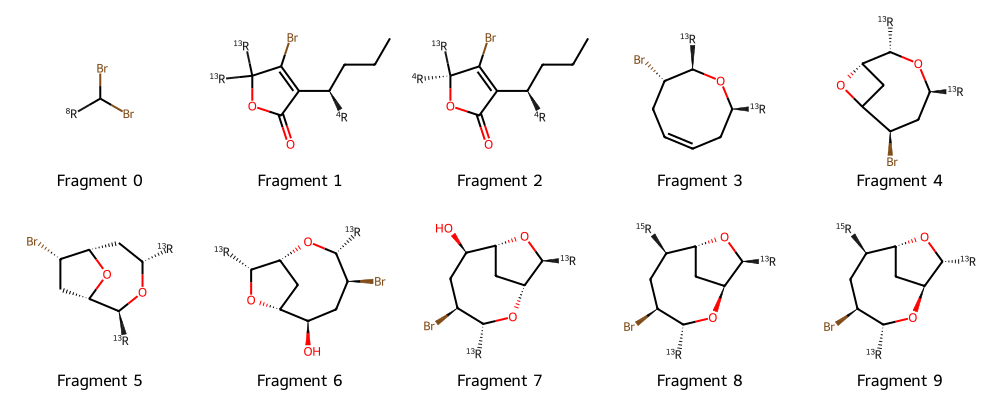

In [7]:
NUM_DISPLAY = 10  # Show only 10 fragments
Draw.MolsToGridImage(
    frags[:NUM_DISPLAY],
    legends=[f"Fragment {i}" for i in range(NUM_DISPLAY)],
    molsPerRow=5
)


# Step 3: Generate Parent-fragment tuples
Pre-requisite: a docked parent molecule from which the fragments will be grown. The fragment should have an open valence (remove a H or -CH3 group). It should be uploaded as lig.sdf

In [43]:
!obabel pdL1_2653v2.pdb -O pdL1_2653v2.sdf

1 molecule converted


Change F to * first in the sdf file before proceeding

In [44]:
from rdkit import Chem

# Load docked ligand (parent)
parent = Chem.MolFromMolFile('pdL1_2653v2.sdf') #load parent ligand (docked fragment) = change filename

# Load fragments from 3D SDF (as previously discussed)
frag_file = 'real_3dFrogs.sdf'
frags = []
with Chem.SDMolSupplier(frag_file, sanitize=False, removeHs=False) as supplier:
    for mol in supplier:
        if mol:
            mol.UpdatePropertyCache(strict=False)
            frags.append(mol)

# Pair: each tuple holds (parent, fragment)
paired_frags = [(parent, frag) for frag in frags]

print(f"Generated {len(paired_frags)} parent–fragment tuples for workflow.")



Generated 3698 parent–fragment tuples for workflow.


[14:10:35] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 8 ignored
[14:10:35] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 8 ignored
[14:10:35] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 8 ignored
[14:10:35] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 9 ignored
[14:10:35] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 9 ignored
[14:10:35] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 3 ignored
[14:10:35] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 8 ignored
[14:10:35] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 10 ignored
[14:10:35] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 8 ignored
[14:10:35] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 10 ignored
[14:10:35] Warning: ambiguous stereochemistry - linear bond arrangement - at at

# Optional: Visualize a random parent-fragment pair

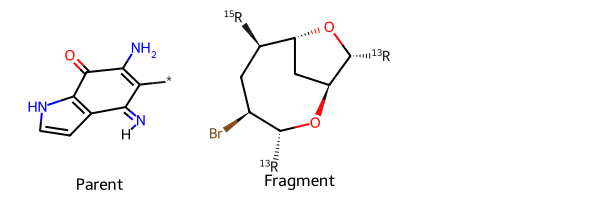

In [45]:
# Example: how to access
FRAG_IDX = 9  # or any index
parent = paired_frags[FRAG_IDX][0]
fragment = paired_frags[FRAG_IDX][1]

# Visualize parent-fragment pair
from rdkit.Chem import Draw
Draw.MolsToGridImage([parent, fragment], legends=["Parent", "Fragment"])


In [46]:
import py3Dmol
from rdkit import Chem

def mol_to_sdf_block(mol):
    from rdkit.Chem import rdmolfiles
    w = rdmolfiles.SDWriter('tmp.sdf')
    w.write(mol)
    w.close()
    with open('tmp.sdf', 'r') as f:
        sdf = f.read()
    return sdf

# Select parent–fragment pair (from your pairing workflow)
FRAG_IDX = 9  # or any index
parent = paired_frags[FRAG_IDX][0]
fragment = paired_frags[FRAG_IDX][1]

# Convert parent and fragment to SDF block for visualization
parent_sdf = mol_to_sdf_block(parent)
fragment_sdf = mol_to_sdf_block(fragment)

# Setup py3Dmol view
view = py3Dmol.view(width=900, height=600)

# Add receptor (rec.pdb) -- cartoon (ribbon) style
with open('PD-L1.pdb', 'r') as f:  # change receptor filename
    pdb_data = f.read()
view.addModel(pdb_data, 'pdb')
view.setStyle({'model': 0}, {'cartoon': {'color':'spectrum'}})
view.addSurface(py3Dmol.VDW, {'opacity':0.7, 'color':'white'})

# Add parent ligand -- stick style
view.addModel(parent_sdf, 'sdf')
view.setStyle({'model': 1}, {'stick': {'colorscheme': 'greenCarbon'}})

# Add fragment -- stick style, highlight in yellow
view.addModel(fragment_sdf, 'sdf')
view.setStyle({'model': 2}, {'stick': {'color': 'yellow'}})

view.zoomTo()
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Step 3: Load DeepFrag Model & Fingerprints

We can load a pretrained DeepFrag model with `LeadoptModel.load`. This function expects a path to a model folder which contains `args.json` describing the model hyperparameters and `voxel.pt` containing the serialized weights of the model.

By default, this model will be loaded on the GPU, however we can pass a PyTorch device to the `device` parameter to load the model on the CPU instead.

In [47]:
USE_CPU = True # True = use CPU for computation; False = use GPU

device = torch.device('cpu') if USE_CPU else torch.device('cuda')
print('Using CPU' if USE_CPU else 'Using GPU')

model = LeadoptModel.load('./final_model', device=device)

with h5py.File('./real_Frogprints.h5', 'r') as f:
  f_smiles = f['smiles'][()]
  f_fingerprints = f['fingerprints'][()].astype(float)

print('Loaded %d fingerprints' % len(f_smiles))

Using CPU
Loaded 3698 fingerprints


## Step 4: Analyze each parent-fragment pair

This loops sections 3, 5, 6 and 7 in the original DeepFrag script, in order to process all fragments

In [48]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
from rdkit import Chem

# Assumed pre-existing from earlier notebook/script cells (Section 0, 1, 4):
# - rec_coords, rec_types: receptor coordinates/types (from util.load_receptor_ob or equivalent)
# - paired_frags: list of (parent, fragment) tuples with proper 3D geometry and dummy atoms
# - util, grid_util: DeepFrag utility modules loaded/imported
# - model: Loaded DeepFrag model object
# - f_smiles, f_fingerprints: loaded fingerprint database as arrays
# - REC_TYPER, LIG_TYPER, DIST_FN: as required by the model/grid_util logic
# - USE_CPU: True/False for device logic

results = []

# Loop over all parent–fragment pairs
for idx in tqdm(range(len(paired_frags)), desc="DeepFrag: Screening all pairs"):
    parent, fragment = paired_frags[idx]

    # --- Section 3: Extract coordinates/types and connection point ---
    parent_coords = util.get_coords(parent)
    parent_types = np.array(util.get_types(parent)).reshape((-1,1))
    conn = util.get_connection_point(fragment)

    # --- Section 5: Grid generation ---
    batch = grid_util.get_raw_batch(
        rec_coords, rec_types,
        parent_coords, parent_types,
        rec_typer=REC_TYPER[model._args['rec_typer']],
        lig_typer=LIG_TYPER[model._args['lig_typer']],
        conn=conn,
        num_samples=32,
        width=model._args['grid_width'],
        res=model._args['grid_res'],
        point_radius=model._args['point_radius'],
        point_type=model._args['point_type'],
        acc_type=model._args['acc_type'],
        cpu=USE_CPU
    )
    batch = torch.as_tensor(batch)

    # --- Section 6: Prediction ---
    pred = model.predict(batch.float()).cpu().numpy()
    avg_fp = np.mean(pred, axis=0)

    # --- Section 7: Similarity scoring ---
    dist_fn = DIST_FN[model._args['dist_fn']]
    dist = dist_fn(
        torch.Tensor(avg_fp).unsqueeze(0),
        torch.Tensor(f_fingerprints)
    )
    dist = dist.numpy().flatten()

    # --- Collect results for this pair (one row per db_smiles/fingerprint) ---
    fragment_smiles = Chem.MolToSmiles(fragment)
    parent_smiles = Chem.MolToSmiles(parent)
    for db_idx, (sm, d) in enumerate(zip(f_smiles, dist)):
        results.append({
            'pair_idx': idx,
            'parent_smiles': parent_smiles,
            'fragment_smiles': fragment_smiles,
            'db_idx': db_idx,
            'db_smiles': sm,
            'distance': d
        })

# --- Write results to CSV ---
df = pd.DataFrame(results)
df.to_csv('pdL1_deepFrag_rawout.csv', index=False) #change file name
print('Results saved to pdL1_deepFrag_rawout.csv')



Results saved to pdL1_deepFrag_rawout.csv


In [ ]:
print('avg_fp shape:', avg_fp.shape)
print('f_fingerprints shape:', f_fingerprints.shape)


# Visualize the outputs and select the best parent-fragment pairs

In [1]:
#load the csv output and visualize the first 5 rows
import pandas as pd
df = pd.read_csv('pdL1_deepFrag_rawout.csv')
df.head()

,pair_idx,parent_smiles,fragment_smiles,db_idx,db_smiles,distance
0,0,*C1=C(N)C(=O)c2[nH]ccc2/C1=N\[H],[8*]C(Br)Br,0,b'[15*][C@@]1(C)[C@@H](O)[C@@H](O)C[C@@]2(C)[C...,0.900768
1,0,*C1=C(N)C(=O)c2[nH]ccc2/C1=N\[H],[8*]C(Br)Br,1,b'[15*][C@@H]1CC/C(C)=C\\CC[C@@]2(C)O[C@@H]2[C...,0.891998
2,0,*C1=C(N)C(=O)c2[nH]ccc2/C1=N\[H],[8*]C(Br)Br,2,b'[13*][C@@H]1Nc2ccccc2-c2cc[nH]c2C1=O',0.999367
3,0,*C1=C(N)C(=O)c2[nH]ccc2/C1=N\[H],[8*]C(Br)Br,3,b'[10*]N1C(=O)C=C2C[C@@H]3C=C(C)CC[C@@H]3C(C)(...,0.970701
4,0,*C1=C(N)C(=O)c2[nH]ccc2/C1=N\[H],[8*]C(Br)Br,4,b'[8*]CC1=CC(=O)C(NC)=CC1=O',0.989013


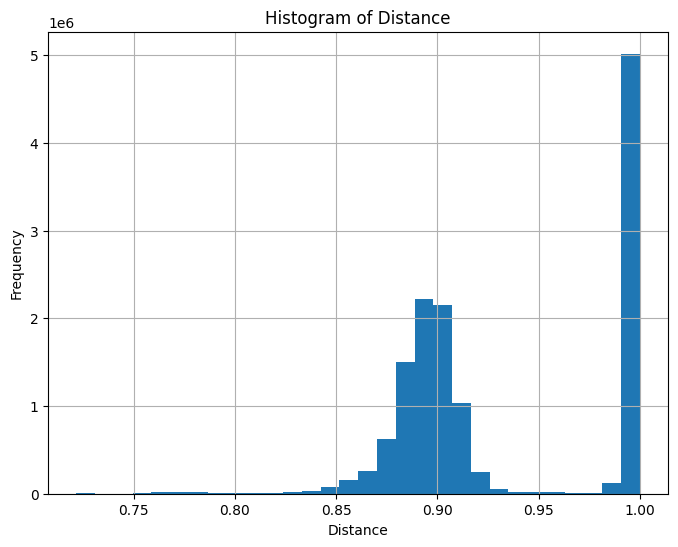

In [3]:
# create a histogram of the distance values
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
df['distance'].hist(bins=30)
plt.title('Histogram of Distance')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

In [2]:
# rank based on ascending distance
df.sort_values(by='distance', ascending=True, inplace=True)
df.head(20)

,pair_idx,parent_smiles,fragment_smiles,db_idx,db_smiles,distance
1803495,487,*C1=C(N)C(=O)c2[nH]ccc2/C1=N\[H],[15*][C@H]1CC[C@H]2[C@@H]3C/C=C4/C[C@@H](O)C[C...,2569,b'[13*][C@@H]1Cc2c([nH]c3c([16*])cccc23)CN1',0.721676
7598261,2054,*C1=C(N)C(=O)c2[nH]ccc2/C1=N\[H],[15*][C@H]1[C@@H](O)C[C@H](O)[C@@]23O[C@@H]2CC...,2569,b'[13*][C@@H]1Cc2c([nH]c3c([16*])cccc23)CN1',0.721934
7062051,1909,*C1=C(N)C(=O)c2[nH]ccc2/C1=N\[H],[15*][C@H]1CC[C@@](C)(O)[C@H]2CCC(C)=C[C@@H]12,2569,b'[13*][C@@H]1Cc2c([nH]c3c([16*])cccc23)CN1',0.722269
12734783,3443,*C1=C(N)C(=O)c2[nH]ccc2/C1=N\[H],[15*][C@]1(C)[C@H]2CCC(CO)=C[C@H]2[C@@H]1C1=CC...,2569,b'[13*][C@@H]1Cc2c([nH]c3c([16*])cccc23)CN1',0.722437
320597,86,*C1=C(N)C(=O)c2[nH]ccc2/C1=N\[H],[16*]C1=CC([16*])=C(O)C(Br)=C1,2569,b'[13*][C@@H]1Cc2c([nH]c3c([16*])cccc23)CN1',0.722479
3989013,1078,*C1=C(N)C(=O)c2[nH]ccc2/C1=N\[H],[15*][C@H]1[C@]2(C)C[C@H](O)[C@]3(C)[C@@H]([15...,2569,b'[13*][C@@H]1Cc2c([nH]c3c([16*])cccc23)CN1',0.722541
6481465,1752,*C1=C(N)C(=O)c2[nH]ccc2/C1=N\[H],[16*]C1=C(C=O)C=C(C)C2=C1C(=O)OC2,2569,b'[13*][C@@H]1Cc2c([nH]c3c([16*])cccc23)CN1',0.722644
13441101,3634,*C1=C(N)C(=O)c2[nH]ccc2/C1=N\[H],[15*][C@H]1CC[C@H](C=C)[C@@H]2C/C=C\C(=O)[C@H]...,2569,b'[13*][C@@H]1Cc2c([nH]c3c([16*])cccc23)CN1',0.722680
8230619,2225,*C1=C(N)C(=O)c2[nH]ccc2/C1=N\[H],[4*][C@]1(C)C[C@@H](O)[C@H]([15*])[C@@H]2[C@H]...,2569,b'[13*][C@@H]1Cc2c([nH]c3c([16*])cccc23)CN1',0.722694
8189941,2214,*C1=C(N)C(=O)c2[nH]ccc2/C1=N\[H],[15*][C@@H]1[C@@H]2[C@@H]([C@H]3C[C@H](C)C(=O)...,2569,b'[13*][C@@H]1Cc2c([nH]c3c([16*])cccc23)CN1',0.722711


In [ ]:
# determine how may fragments fall within 0.01 of the lowest distance
min_distance = df['distance'].min()
within_tolerance = df[df['distance'] <= min_distance + 0.005]
count = within_tolerance.shape[0]
print(count)


# Step 5: Embed 100 best scoring fragments to parent

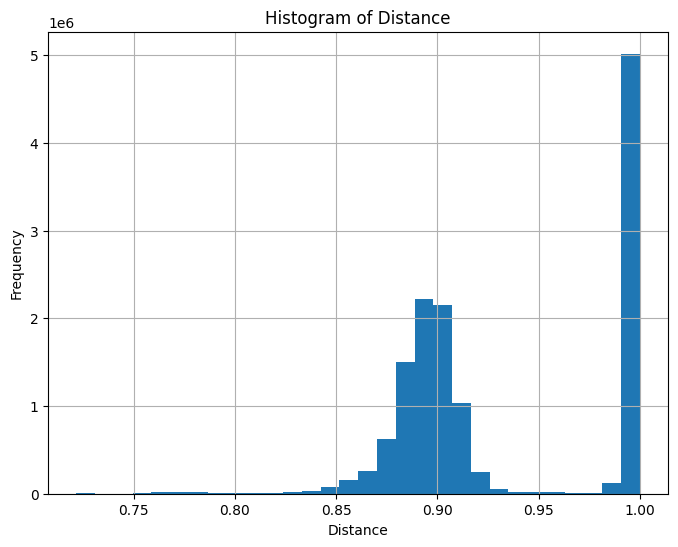

Loaded receptor with 782 atoms


Processing fragments:   0%|                             | 0/100 [00:00<?, ?it/s]

Processing top 100 fragments with lowest distance scores


[15:15:47] Molecule does not have explicit Hs. Consider calling AddHs()
[15:15:47] UFFTYPER: Unrecognized atom type: *_ (0)
[15:15:47] Molecule does not have explicit Hs. Consider calling AddHs()
[15:15:47] UFFTYPER: Unrecognized atom type: *_ (0)
[15:15:47] UFFTYPER: Unrecognized atom type: *_ (22)

Sampling conformations:   0%|                             | 0/3 [00:00<?, ?it/s][15:15:49] UFFTYPER: Unrecognized atom type: *_ (34)
[15:15:49] Molecule does not have explicit Hs. Consider calling AddHs()
[15:15:49] UFFTYPER: Unrecognized atom type: *_ (816)
[15:15:49] Molecule does not have explicit Hs. Consider calling AddHs()
[15:15:49] UFFTYPER: Unrecognized atom type: *_ (816)
[15:15:49] Molecule does not have explicit Hs. Consider calling AddHs()
[15:15:49] UFFTYPER: Unrecognized atom type: *_ (816)
[15:15:49] Molecule does not have explicit Hs. Consider calling AddHs()
[15:15:49] UFFTYPER: Unrecognized atom type: *_ (816)
[15:15:49] Molecule does not have explicit Hs. Consider calli

Error processing row 12949267: Invariant Violation
	bad lower bound
	Violation occurred on line 187 in file Code/GraphMol/DistGeomHelpers/BoundsMatrixBuilder.cpp
	Failed Expression: lb > DIST12_DELTA || clb > DIST12_DELTA
	RDKIT: 2023.09.2
	BOOST: 1_78




Sampling conformations:   0%|                             | 0/2 [00:00<?, ?it/s][15:16:02] UFFTYPER: Unrecognized atom type: *_ (20)
[15:16:02] UFFTYPER: Unrecognized atom type: *_ (29)
[15:16:02] Molecule does not have explicit Hs. Consider calling AddHs()
[15:16:02] UFFTYPER: Unrecognized atom type: *_ (802)
[15:16:02] UFFTYPER: Unrecognized atom type: *_ (811)
[15:16:02] Molecule does not have explicit Hs. Consider calling AddHs()
[15:16:02] UFFTYPER: Unrecognized atom type: *_ (802)
[15:16:02] UFFTYPER: Unrecognized atom type: *_ (811)
[15:16:02] Molecule does not have explicit Hs. Consider calling AddHs()
[15:16:02] UFFTYPER: Unrecognized atom type: *_ (802)
[15:16:02] UFFTYPER: Unrecognized atom type: *_ (811)
[15:16:02] Molecule does not have explicit Hs. Consider calling AddHs()
[15:16:02] UFFTYPER: Unrecognized atom type: *_ (802)
[15:16:02] UFFTYPER: Unrecognized atom type: *_ (811)
[15:16:02] Molecule does not have explicit Hs. Consider calling AddHs()
[15:16:02] UFFTYPER: 

Error processing row 10316291: Invariant Violation
	bad lower bound
	Violation occurred on line 187 in file Code/GraphMol/DistGeomHelpers/BoundsMatrixBuilder.cpp
	Failed Expression: lb > DIST12_DELTA || clb > DIST12_DELTA
	RDKIT: 2023.09.2
	BOOST: 1_78




Sampling conformations:   0%|                             | 0/1 [00:00<?, ?it/s][15:16:16] Molecule does not have explicit Hs. Consider calling AddHs()
[15:16:16] Molecule does not have explicit Hs. Consider calling AddHs()
[15:16:16] Molecule does not have explicit Hs. Consider calling AddHs()
[15:16:16] Molecule does not have explicit Hs. Consider calling AddHs()
[15:16:16] Molecule does not have explicit Hs. Consider calling AddHs()
[15:16:16] Molecule does not have explicit Hs. Consider calling AddHs()
[15:16:16] Molecule does not have explicit Hs. Consider calling AddHs()

Processing fragments:  32%|██████▍             | 32/100 [00:29<00:43,  1.56it/s][15:16:16] Molecule does not have explicit Hs. Consider calling AddHs()
[15:16:16] UFFTYPER: Unrecognized atom type: *_ (0)
[15:16:16] Molecule does not have explicit Hs. Consider calling AddHs()
[15:16:16] UFFTYPER: Unrecognized atom type: *_ (0)

Sampling conformations:   0%|                             | 0/1 [00:00<?, ?it/s][15:1

Error processing row 2469135: Invariant Violation
	bad lower bound
	Violation occurred on line 187 in file Code/GraphMol/DistGeomHelpers/BoundsMatrixBuilder.cpp
	Failed Expression: lb > DIST12_DELTA || clb > DIST12_DELTA
	RDKIT: 2023.09.2
	BOOST: 1_78

Error processing row 7797953: Invariant Violation
	bad lower bound
	Violation occurred on line 187 in file Code/GraphMol/DistGeomHelpers/BoundsMatrixBuilder.cpp
	Failed Expression: lb > DIST12_DELTA || clb > DIST12_DELTA
	RDKIT: 2023.09.2
	BOOST: 1_78



[15:19:39] Molecule does not have explicit Hs. Consider calling AddHs()
[15:19:39] Molecule does not have explicit Hs. Consider calling AddHs()

Processing fragments:  55%|███████████         | 55/100 [03:52<02:17,  3.06s/it][15:19:39] Molecule does not have explicit Hs. Consider calling AddHs()
[15:19:39] UFFTYPER: Unrecognized atom type: *_ (0)
[15:19:39] Molecule does not have explicit Hs. Consider calling AddHs()
[15:19:39] UFFTYPER: Unrecognized atom type: *_ (0)

Sampling conformations:   0%|                             | 0/1 [00:00<?, ?it/s][15:19:40] Molecule does not have explicit Hs. Consider calling AddHs()
[15:19:40] Molecule does not have explicit Hs. Consider calling AddHs()
[15:19:40] Molecule does not have explicit Hs. Consider calling AddHs()
[15:19:40] Molecule does not have explicit Hs. Consider calling AddHs()
[15:19:40] Molecule does not have explicit Hs. Consider calling AddHs()
[15:19:40] Molecule does not have explicit Hs. Consider calling AddHs()
[15:19:40] Mol

Error processing row 8249109: Invariant Violation
	bad lower bound
	Violation occurred on line 187 in file Code/GraphMol/DistGeomHelpers/BoundsMatrixBuilder.cpp
	Failed Expression: lb > DIST12_DELTA || clb > DIST12_DELTA
	RDKIT: 2023.09.2
	BOOST: 1_78



[15:19:42] Molecule does not have explicit Hs. Consider calling AddHs()
[15:19:43] Molecule does not have explicit Hs. Consider calling AddHs()
[15:19:43] Molecule does not have explicit Hs. Consider calling AddHs()
[15:19:43] Molecule does not have explicit Hs. Consider calling AddHs()
[15:19:43] Molecule does not have explicit Hs. Consider calling AddHs()

Processing fragments:  61%|████████████▏       | 61/100 [03:55<00:36,  1.06it/s][15:19:43] Molecule does not have explicit Hs. Consider calling AddHs()
[15:19:43] UFFTYPER: Unrecognized atom type: *_ (0)
[15:19:43] Molecule does not have explicit Hs. Consider calling AddHs()
[15:19:43] UFFTYPER: Unrecognized atom type: *_ (0)

Sampling conformations:   0%|                             | 0/1 [00:00<?, ?it/s][15:19:43] Molecule does not have explicit Hs. Consider calling AddHs()
[15:19:43] Molecule does not have explicit Hs. Consider calling AddHs()
[15:19:43] Molecule does not have explicit Hs. Consider calling AddHs()
[15:19:43] Mol

[15:32:44] UFFTYPER: Unrecognized atom type: *_ (804)
[15:32:44] Molecule does not have explicit Hs. Consider calling AddHs()
[15:32:44] UFFTYPER: Unrecognized atom type: *_ (804)
[15:32:44] Molecule does not have explicit Hs. Consider calling AddHs()
[15:32:44] UFFTYPER: Unrecognized atom type: *_ (804)
[15:32:44] Molecule does not have explicit Hs. Consider calling AddHs()
[15:32:44] UFFTYPER: Unrecognized atom type: *_ (804)
[15:32:44] Molecule does not have explicit Hs. Consider calling AddHs()

Sampling conformations:  50%|██████████▌          | 1/2 [00:00<00:00,  4.17it/s][15:32:44] combineMols: conformer id 0 not found in mol2[15:32:44] UFFTYPER: Unrecognized atom type: *_ (22)
[15:32:44] Molecule does not have explicit Hs. Consider calling AddHs()

Processing fragments:  90%|█████████████████  | 90/100 [16:57<26:09, 156.98s/it][15:32:44] Molecule does not have explicit Hs. Consider calling AddHs()
[15:32:44] UFFTYPER: Unrecognized atom type: *_ (0)
[15:32:44] Molecule does not 

Results saved to step5_pdL1_2653v2.csv

Embedding Summary:
Total fragments processed: 95
Successful embeddings: 94
Success rate: 98.9%
Average best energy: 358785146.81
Embedding completed successfully!
Successfully embedded 94 fragments

Top 10 results by energy:
    db_idx  distance  best_energy  \
31    2569  0.723163  1679.078854   
84    2569  0.723523  1684.742483   
91    2569  0.723541  1686.670964   
63    2569  0.723419  1687.080948   
4     2569  0.722479  1692.542942   
67    2569  0.723441  1693.822074   
30    2569  0.723162  1694.998877   
54    2569  0.723356  1700.333816   
40    2569  0.723265  1702.440569   
55    2569  0.723388  1707.532433   

                                      embedded_smiles  
31  [H]/N=C1/C(C([H])(Br)/C([H])=C(/[H])Br)=C(N)C(...  
84  [15*][C@]1([H])C([H])([H])[C@@]([H])(C([H])=C=...  
91  [8*][C@@]([H])(Br)C([H])([H])[C@]([H])(O[H])C(...  
63  [H]/N=C1/C(C([H])(Br)[C@]([H])(O[H])C([H])(Br)...  
4   [16*]c1c([H])c(C2=C(N)C(=O)c3[nH]ccc3/C2=N\

In [50]:

# ========================================
# DeepFrag Step 5 - Fragment Embedding
# Usage Example and Documentation
# ========================================

import pandas as pd
from DeepFrag_step5_inhouse import process_deepfrag_step5

# 1. Load your step 4 results (adjust the filename as needed)
df_step4 = pd.read_csv('pdL1_deepFrag_rawout.csv')
df_step4.head()

# create a histogram of the distance values
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
df_step4['distance'].hist(bins=30)
plt.title('Histogram of Distance')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

# The step 4 DataFrame should have these columns:
# - pair_idx: Index of the parent-fragment pair
# - parent_smiles: SMILES string of parent molecule (with dummy atoms *)
# - fragment_smiles: SMILES string of fragment (with dummy atoms like [8*])
# - db_idx: Database index of the fragment
# - db_smiles: Database SMILES of the fragment
# - distance: Distance score for ranking

# 2. Run the embedding process    change filenames every run
df_step5 = process_deepfrag_step5(
    df_step4=df_step4,
    receptor_path='PD-L1.pdb',  # Path to your receptor PDB file; change name as needed
    output_file='step5_pdL1_2653v2.csv',     #change name of output file
    top_n=100,  # Process top 50 fragments with lowest distance scores
    max_conformers=5,  # Number of conformers to sample (reduced for efficiency)
    angle_step=60  # Dihedral angle step in degrees (larger = faster)
)

# 3. Check results
if df_step5 is not None:
    print("Embedding completed successfully!")

    # Show successful embeddings
    successful = df_step5[df_step5['embedding_success'] == True]
    print(f"Successfully embedded {len(successful)} fragments")

    # Sort by best energy to find most favorable embeddings
    best_results = successful.sort_values('best_energy').head(10)
    print("\nTop 10 results by energy:")
    print(best_results[['db_idx', 'distance', 'best_energy', 'embedded_smiles']])

# ========================================
# Output Columns Explanation:
# ========================================
# - All original columns from step 4 are preserved
# - embedded_smiles: SMILES of the combined parent+fragment molecule
# - best_energy: Lowest energy found during conformational sampling
# - num_conformers_sampled: Number of conformations tested
# - embedding_success: Boolean indicating if embedding was successful

# ========================================
# Performance Tuning:
# ========================================
# - Increase max_conformers for more thorough sampling (slower)
# - Decrease angle_step for finer dihedral sampling (slower)
# - Adjust top_n to process more or fewer fragments
# - The code includes error handling to continue even if some fragments fail

# ========================================
# Troubleshooting:
# ========================================
# 1. Make sure your receptor PDB file is accessible and valid
# 2. Ensure your step 4 CSV has the required columns
# 3. Check that SMILES strings are valid and contain dummy atoms
# 4. Monitor the console output for error messages and success rates

# Revised and improved embedding script


In [4]:
import pandas as pd
import sys
sys.path.append('.')  # Add current directory to path

# Import the modified 3D fragment embedding script
from fragment_embedding_3d import process_fragment_database_3d, test_embedding_example_3d

# Test with the example first using 3D coordinates
print("=== Testing with Example Parent-Fragment Pair (3D Coordinates) ===")
test_result = test_embedding_example_3d()
print("\n" + "="*60 + "\n")

=== Testing with Example Parent-Fragment Pair (3D Coordinates) ===
Testing with example parent-fragment pair using 3D coordinates:
Parent: *C[C@]1(C)C[C@@H](O)C[C@]2(C)O[C@@H]12
Fragment: [7*]CC1=C(Cl)[C@@H](O)[C@@H](O)[C@@H]1O
Embedded SMILES: C[C@@]1(CCC2=C(Cl)[C@@H](O)[C@@H](O)[C@@H]2O)C[C@@H](O)C[C@]2(C)O[C@@H]12




[18:36:02] UFFTYPER: Unrecognized atom type: *_ (0)
[18:36:02] UFFTYPER: Unrecognized atom type: *_ (0)


In [5]:
# Jupyter Notebook Code to Run 3D Fragment Embedding
# Run this in a Jupyter notebook cell to process your CSV database with 3D coordinates

# Process your CSV database with 3D embedding
print("=== Processing CSV Database with 3D Fragment Embedding ===")

# Specify your input CSV file path
input_csv_path = "pdL1_forEmbedding.csv"  # Replace with your actual CSV file path

# Specify output CSV file path (optional - if None, will overwrite input file)
output_csv_path = "pdL1_revEmbedded_3d.csv"  # Replace with desired output path

# Specify column names (adjust these to match your CSV)
parent_column_name = "parent_smiles"      # Replace with actual parent column name
fragment_column_name = "fragment_smiles"  # Replace with actual fragment column name

# Process the database with 3D embedding
try:
    result_df = process_fragment_database_3d(
        input_csv=input_csv_path,
        output_csv=output_csv_path,
        parent_col=parent_column_name,
        fragment_col=fragment_column_name
    )
    
    if result_df is not None:
        print("\n=== Sample Results (3D Embedding) ===")
        print("First 5 rows with 3D embedding results:")
        print(result_df[['parent', 'fragment', 'embedded_smiles']].head())
        
        # Show some statistics
        print("\n=== Detailed 3D Embedding Statistics ===")
        total_rows = len(result_df)
        successful_embeddings = result_df['embedded_smiles'].notna().sum()
        failed_embeddings = result_df['embedded_smiles'].isna().sum()
        
        print(f"Total rows processed: {total_rows}")
        print(f"Successful 3D embeddings: {successful_embeddings}")
        print(f"Failed 3D embeddings: {failed_embeddings}")
        print(f"3D embedding success rate: {(successful_embeddings/total_rows)*100:.2f}%")
        
        # Show examples of successful 3D embeddings
        successful_examples = result_df[result_df['embedded_smiles'].notna()].head(3)
        if not successful_examples.empty:
            print("\n=== Examples of Successful 3D Embeddings ===")
            for idx, row in successful_examples.iterrows():
                print(f"\nRow {idx}:")
                print(f"  Parent:    {row['parent']}")
                print(f"  Fragment:  {row['fragment']}")
                print(f"  Embedded:  {row['embedded_smiles']}")
        
        # Show examples of failed embeddings (if any)
        failed_examples = result_df[result_df['embedded_smiles'].isna()].head(3)
        if not failed_examples.empty:
            print("\n=== Examples of Failed 3D Embeddings ===")
            for idx, row in failed_examples.iterrows():
                print(f"\nRow {idx}:")
                print(f"  Parent:    {row['parent']}")
                print(f"  Fragment:  {row['fragment']}")
                print(f"  Embedded:  None (failed)")
    
except FileNotFoundError:
    print(f"Error: Could not find the input CSV file: {input_csv_path}")
    print("Please make sure the file path is correct and the file exists.")
    
except Exception as e:
    print(f"An error occurred during 3D embedding: {e}")

# Optional: Analyze 3D molecular properties of embedded results
print("\n=== Optional: 3D Molecular Property Analysis ===")
print("Uncomment the code below to analyze 3D properties of embedded molecules")


print("\n=== 3D Fragment Embedding Complete ===")
print("3D coordinates have been used throughout the embedding process for:")
print("- Better molecular geometry during hydrogen addition")
print("- Improved conformer generation using ETKDG algorithm")
print("- Force field optimization (MMFF/UFF) of 3D structures")
print("- Enhanced fragment joining with 3D coordinate preservation")

Embedding fragments (3D):   0%|                         | 0/544 [00:00<?, ?it/s]

=== Processing CSV Database with 3D Fragment Embedding ===
Loading database from pdL1_forEmbedding.csv...
Loaded 544 parent-fragment pairs
Processing parent-fragment pairs with 3D geometry...


[18:46:25] UFFTYPER: Unrecognized atom type: *_ (0)
[18:46:26] UFFTYPER: Unrecognized atom type: *_ (0)
Embedding fragments (3D):   0%|                 | 1/544 [00:01<09:53,  1.09s/it][18:46:27] UFFTYPER: Unrecognized atom type: *_ (0)
[18:46:28] UFFTYPER: Unrecognized atom type: *_ (0)
[18:46:28] UFFTYPER: Unrecognized atom type: *_ (6)
Embedding fragments (3D):   0%|                 | 2/544 [00:02<10:01,  1.11s/it][18:46:28] UFFTYPER: Unrecognized atom type: *_ (0)
[18:46:29] UFFTYPER: Unrecognized atom type: *_ (0)
[18:46:29] UFFTYPER: Unrecognized atom type: *_ (2)
Embedding fragments (3D):   1%|                 | 3/544 [00:03<10:04,  1.12s/it][18:46:29] UFFTYPER: Unrecognized atom type: *_ (0)
[18:46:30] UFFTYPER: Unrecognized atom type: *_ (0)
Embedding fragments (3D):   1%|▏                | 4/544 [00:04<10:02,  1.12s/it][18:46:30] UFFTYPER: Unrecognized atom type: *_ (0)
[18:46:31] UFFTYPER: Unrecognized atom type: *_ (0)
Embedding fragments (3D):   1%|▏                | 5/544 

3D embedding failed, trying distance geometry...


[18:46:50] UFFTYPER: Unrecognized atom type: *_ (0)
Embedding fragments (3D):   4%|▌               | 20/544 [00:29<28:26,  3.26s/it][18:46:54] UFFTYPER: Unrecognized atom type: *_ (0)
[18:46:55] UFFTYPER: Unrecognized atom type: *_ (0)
Embedding fragments (3D):   4%|▌               | 21/544 [00:30<22:44,  2.61s/it][18:46:56] UFFTYPER: Unrecognized atom type: *_ (0)
[18:46:57] UFFTYPER: Unrecognized atom type: *_ (0)
[18:46:57] UFFTYPER: Unrecognized atom type: *_ (6)
[18:46:57] UFFTYPER: Unrecognized atom type: *_ (8)
Embedding fragments (3D):   4%|▋               | 22/544 [00:31<18:40,  2.15s/it][18:46:57] UFFTYPER: Unrecognized atom type: *_ (0)
[18:46:58] UFFTYPER: Unrecognized atom type: *_ (0)
[18:46:58] UFFTYPER: Unrecognized atom type: *_ (16)
Embedding fragments (3D):   4%|▋               | 23/544 [00:32<15:47,  1.82s/it][18:46:58] UFFTYPER: Unrecognized atom type: *_ (0)
[18:46:59] UFFTYPER: Unrecognized atom type: *_ (0)
Embedding fragments (3D):   4%|▋               | 24/544

3D embedding failed, trying distance geometry...


[18:48:11] UFFTYPER: Unrecognized atom type: *_ (0)
Embedding fragments (3D):  20%|██▉            | 107/544 [01:45<01:34,  4.64it/s][18:48:11] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:11] UFFTYPER: Unrecognized atom type: *_ (0)
Embedding fragments (3D):  20%|██▉            | 108/544 [01:45<01:18,  5.52it/s][18:48:11] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:11] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:11] UFFTYPER: Unrecognized atom type: *_ (10)
[18:48:11] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:11] UFFTYPER: Unrecognized atom type: *_ (0)
Embedding fragments (3D):  20%|███            | 110/544 [01:46<01:03,  6.88it/s][18:48:11] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:12] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:12] UFFTYPER: Unrecognized atom type: *_ (6)
[18:48:12] UFFTYPER: Unrecognized atom type: *_ (22)
[18:48:12] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:12] UFFTYPER: Unrecognized atom type: *_ (0)
Embedding fragments (3D):  21%

3D embedding failed, trying distance geometry...


[18:48:19] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:19] UFFTYPER: Unrecognized atom type: *_ (18)
[18:48:22] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:22] UFFTYPER: Unrecognized atom type: *_ (0)
Embedding fragments (3D):  37%|█████▌         | 202/544 [01:56<02:36,  2.18it/s][18:48:22] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:22] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:22] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:22] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:22] UFFTYPER: Unrecognized atom type: *_ (14)
[18:48:22] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:22] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:22] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:22] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:22] UFFTYPER: Unrecognized atom type: *_ (2)
[18:48:22] UFFTYPER: Unrecognized atom type: *_ (12)
[18:48:22] UFFTYPER: Unrecognized atom type: *_ (15)
Embedding fragments (3D):  38%|█████▋         | 206/544 [01:56<01:51,  3.04it/s][18:

3D embedding failed, trying distance geometry...


[18:48:28] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:28] UFFTYPER: Unrecognized atom type: *_ (15)
[18:48:33] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:33] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:33] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:33] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:33] UFFTYPER: Unrecognized atom type: *_ (6)
[18:48:33] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:33] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:33] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:33] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:33] UFFTYPER: Unrecognized atom type: *_ (8)
Embedding fragments (3D):  58%|████████▋      | 315/544 [02:07<02:05,  1.82it/s][18:48:33] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:33] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:33] UFFTYPER: Unrecognized atom type: *_ (21)
[18:48:33] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:33] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:33] UFFTYPER: Unrecognized 

3D embedding failed, trying distance geometry...


[18:48:48] UFFTYPER: Unrecognized atom type: *_ (0)
[18:48:48] UFFTYPER: Unrecognized atom type: *_ (14)
Embedding fragments (3D):  65%|█████████▋     | 353/544 [02:40<14:26,  4.53s/it][18:49:05] UFFTYPER: Unrecognized atom type: *_ (0)
[18:49:05] UFFTYPER: Unrecognized atom type: *_ (0)
[18:49:05] UFFTYPER: Unrecognized atom type: *_ (10)
[18:49:05] UFFTYPER: Unrecognized atom type: *_ (0)
[18:49:05] UFFTYPER: Unrecognized atom type: *_ (0)
[18:49:06] UFFTYPER: Unrecognized atom type: *_ (0)
[18:49:06] UFFTYPER: Unrecognized atom type: *_ (0)
[18:49:06] UFFTYPER: Unrecognized atom type: *_ (0)
[18:49:06] UFFTYPER: Unrecognized atom type: *_ (0)
[18:49:06] UFFTYPER: Unrecognized atom type: *_ (20)
[18:49:06] UFFTYPER: Unrecognized atom type: *_ (22)
[18:49:06] UFFTYPER: Unrecognized atom type: *_ (0)
[18:49:06] UFFTYPER: Unrecognized atom type: *_ (0)
Embedding fragments (3D):  66%|█████████▊     | 358/544 [02:40<09:51,  3.18s/it][18:49:06] UFFTYPER: Unrecognized atom type: *_ (0)
[18:


Results saved to pdL1_revEmbedded_3d.csv

3D Embedding Summary:
Total parent-fragment pairs: 544
Successfully embedded: 544
Success rate: 100.0%
Failed embeddings: 0

=== Sample Results (3D Embedding) ===
First 5 rows with 3D embedding results:
An error occurred during 3D embedding: "['parent', 'fragment'] not in index"

=== Optional: 3D Molecular Property Analysis ===
Uncomment the code below to analyze 3D properties of embedded molecules

=== 3D Fragment Embedding Complete ===
3D coordinates have been used throughout the embedding process for:
- Better molecular geometry during hydrogen addition
- Improved conformer generation using ETKDG algorithm
- Force field optimization (MMFF/UFF) of 3D structures
- Enhanced fragment joining with 3D coordinate preservation


In [8]:

# Uncomment this section to analyze 3D properties
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Descriptors
from rdkit.Chem import AllChem
import numpy as np

if result_df is not None:
    # Analyze 3D properties of successfully embedded molecules
    successful_embedded = result_df[result_df['embedded_smiles'].notna()]
    
    if not successful_embedded.empty:
        print("Analyzing 3D molecular properties...")
        
        # Calculate molecular properties for embedded molecules
        properties = []
        for _, row in successful_embedded.head(10).iterrows():  # Analyze first 10 successful embeddings
            smiles = row['embedded_smiles']
            mol = Chem.MolFromSmiles(smiles)
            
            if mol:
                # Add hydrogens and generate 3D coordinates for property calculation
                mol_3d = Chem.AddHs(mol)
                AllChem.EmbedMolecule(mol_3d, AllChem.ETKDGv3())
                
                props = {
                    'SMILES': smiles,
                    'Molecular_Weight': Descriptors.MolWt(mol),
                    'LogP': Descriptors.MolLogP(mol),
                    'TPSA': rdMolDescriptors.CalcTPSA(mol),
                    'Num_Rotatable_Bonds': rdMolDescriptors.CalcNumRotatableBonds(mol),
                    'Num_HBD': rdMolDescriptors.CalcNumHBD(mol),
                    'Num_HBA': rdMolDescriptors.CalcNumHBA(mol),
                    'Num_Heavy_Atoms': mol.GetNumHeavyAtoms()
                }
                properties.append(props)
        
        # Create DataFrame with molecular properties
        props_df = pd.DataFrame(properties)
        print("\n3D Embedded Molecule Properties:")
        print(props_df.to_string(index=False, float_format='%.2f'))
        
        # Calculate summary statistics
        print("\n3D Property Summary Statistics:")
        numeric_cols = ['Molecular_Weight', 'LogP', 'TPSA', 'Num_Rotatable_Bonds', 
                       'Num_HBD', 'Num_HBA', 'Num_Heavy_Atoms']
        summary_stats = props_df[numeric_cols].describe()
        print(summary_stats.round(2))


# Optional: Visualize 3D structures using RDKit
print("\n=== Optional: 3D Structure Visualization ===")
print("Uncomment the code below to visualize 3D structures of embedded molecules")





Analyzing 3D molecular properties...


[18:50:57] UFFTYPER: Unrecognized atom type: *_ (0)
[18:50:58] UFFTYPER: Unrecognized atom type: *_ (0)
[18:51:00] UFFTYPER: Unrecognized atom type: *_ (0)
[18:51:00] UFFTYPER: Unrecognized atom type: *_ (0)
[18:51:00] UFFTYPER: Unrecognized atom type: *_ (0)



3D Embedded Molecule Properties:
                                                                                               SMILES  Molecular_Weight  LogP   TPSA  Num_Rotatable_Bonds  Num_HBD  Num_HBA  Num_Heavy_Atoms
                   C/C=c1\[nH]c(=O)/c(=C/c2c(C[C@]34C[C@H](O)CC(C)(C)[C@@H]3O4)[nH]c3ccccc23)[nH]c1=O            421.50  1.03 114.27                    3        4        4               31
   [15*][C@]1(O)CC[C@H]2[C@H](C[C@]34C[C@H](O)CC(C)(C)[C@@H]3O4)[C@@H]3C(C)=CC=C[C@]3(C)C(=O)C[C@H]21            399.55  3.69  70.06                    2        2        4               29
                                  [13*]C1(C[C@]23C[C@H](O)CC(C)(C)[C@@H]2O3)OC(=O)C([C@H](O)CCC)=C1Br            388.28  2.31  79.29                    5        2        5               23
                      C=C1C=C[C@H]2[C@H](O)[C@@H](C)CC[C@@H]2[C@@H]1C[C@]12C[C@H](O)CC(C)(C)[C@@H]1O2            332.48  3.46  52.99                    2        2        3               24
                 C[C@

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3D structure of embedded molecule:
SMILES: C/C=c1\[nH]c(=O)/c(=C/c2c(C[C@]34C[C@H](O)CC(C)(C)[C@@H]3O4)[nH]c3ccccc23)[nH]c1=O
2D structure for comparison:


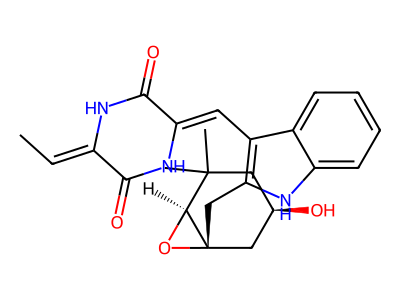

In [9]:
# Uncomment this section to visualize 3D structures
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from IPython.display import display
import py3Dmol

if result_df is not None:
    # Get first successful embedding for 3D visualization
    successful_row = result_df[result_df['embedded_smiles'].notna()].iloc[0]
    
    embedded_smiles = successful_row['embedded_smiles']
    embedded_mol = Chem.MolFromSmiles(embedded_smiles)
    
    if embedded_mol:
        # Add hydrogens and generate 3D coordinates
        embedded_mol_3d = Chem.AddHs(embedded_mol)
        AllChem.EmbedMolecule(embedded_mol_3d, AllChem.ETKDGv3())
        AllChem.MMFFOptimizeMolecule(embedded_mol_3d)
        
        # Generate SDF block for 3D visualization
        sdf_block = Chem.MolToMolBlock(embedded_mol_3d)
        
        # Create 3D viewer
        viewer = py3Dmol.view(width=400, height=300)
        viewer.addModel(sdf_block, 'sdf')
        viewer.setStyle({'stick': {}})
        viewer.zoomTo()
        viewer.show()
        
        print("3D structure of embedded molecule:")
        print(f"SMILES: {embedded_smiles}")
        
        # Also show 2D structure for comparison
        embedded_img = Draw.MolToImage(embedded_mol, size=(400, 300))
        print("2D structure for comparison:")
        display(embedded_img)


# Sanitize and fix embedded molecules in prep for vinascreen
merge multiple csv files into one. the csv file should have ID and SMILES column

In [11]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.PandasTools import WriteSDF
from tqdm import tqdm
import sys

# User input: Set your file names and prefix here
input_csv = '/home/nikka/deepFrog/pdL1_unfiltered.csv'
output_sdf = '/home/nikka/Frag_output/PDL1/pdL1G1_embed.sdf'
user_prefix = 'pdL1G1_'
logfile = 'sanitizesPDL1G1_log.txt'

df = pd.read_csv(input_csv)

def sanitize_and_fix(smiles, molid, logf):
    try:
        mol = Chem.MolFromSmiles(smiles, sanitize=False)
        if mol is None:
            logf.write(f"{molid}: Could not parse SMILES: {smiles}\n")
            return None
        try:
            Chem.SanitizeMol(mol, catchErrors=True)
            mol.UpdatePropertyCache(strict=False)
            Chem.SanitizeMol(mol)
        except Exception as e1:
            try:
                Chem.Kekulize(mol, clearAromaticFlags=True)
                Chem.SanitizeMol(mol)
            except Exception as e2:
                logf.write(f"{molid}: Sanitization failed after kekulize. SMILES={smiles}. e1={str(e1)}; e2={str(e2)}\n")
                return None
        mol.SetProp("ID", molid)
        return mol
    except Exception as e:
        logf.write(f"{molid}: Unexpected error during sanitize_and_fix: {str(e)}\n")
        return None

def mol_add3d_and_hs(mol, molid, logf):
    try:
        mol = Chem.AddHs(mol)
        params = AllChem.ETKDGv3()
        params.randomSeed = 0xf00d
        ok = AllChem.EmbedMolecule(mol, params)
        if ok != 0:
            logf.write(f"{molid}: 3D embedding failed.\n")
            return None
        AllChem.UFFOptimizeMolecule(mol)
        return mol
    except Exception as e:
        logf.write(f"{molid}: Unexpected error during 3D/hydrogen: {str(e)}\n")
        return None

def filter_unique_molecules(mol_list, logf):
    unique = {}
    for mol in tqdm(mol_list, desc="Deduplicating", leave=True):
        try:
            smiles = Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)
            if smiles not in unique:
                unique[smiles] = mol
        except Exception as e:
            logf.write(f"Error during deduplication: {str(e)}\n")
    return list(unique.values())

# Silence RDKit logger
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# Silence Python stdout temporarily during molecule processing
class DummyFile:
    def write(self, x): pass
    def flush(self): pass

# Prepare results with progress. All verbose output is redirected to file.
mols_out = []
ids_out = []
with open(logfile, 'w') as logf:
    print("Processing molecules (sanitize/fix/3D)...")
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing molecules", leave=True):
        origid = str(row['ID'])
        smi = str(row['SMILES'])
        molid = f"{user_prefix}{origid}"
        sys.stdout, orig_stdout = DummyFile(), sys.stdout
        try:
            mol = sanitize_and_fix(smi, molid, logf)
            if mol is None:
                continue
            mol3d = mol_add3d_and_hs(mol, molid, logf)
            if mol3d is None:
                continue
            mol3d.SetProp("ID", molid)
            mol3d.SetProp("_Name", molid)
            mols_out.append(mol3d)
            ids_out.append(molid)
        finally:
            sys.stdout = orig_stdout

    # Deduplicate with progress (messages suppressed)
    sys.stdout, orig_stdout = DummyFile(), sys.stdout
    try:
        unique_mols_out = filter_unique_molecules(mols_out, logf)
    finally:
        sys.stdout = orig_stdout

# Write SDF with progress (messages suppressed)
w = Chem.SDWriter(output_sdf)
for mol in tqdm(unique_mols_out, desc="Writing to SDF", leave=True):
    w.write(mol)
w.close()
# Final summary can be written to logfile or left out for completely silent operation


Processing molecules:   0%|                     | 1/544 [00:00<01:24,  6.46it/s]

Processing molecules (sanitize/fix/3D)...


Writing to SDF: 100%|███████████████████████| 526/526 [00:00<00:00, 6313.79it/s]
